In [98]:
# Imports
import pandas as pd
import numpy as np
from pydub import AudioSegment
import noisereduce as nr
import soundfile as sf
from pydub.playback import play

import matplotlib.pyplot as plt
from scipy.signal import spectrogram

import ipywidgets as widgets
from IPython.display import display

In [99]:
# Load the audio file
audio_file = "../keylogger/output.wav"
data, sample_rate = sf.read(audio_file)

In [100]:
# Reduce noise
reduced_noise = nr.reduce_noise(y=data, sr=sample_rate, prop_decrease=.75)

# Save the cleaned audio to a new file
output_file = "../cleaned_output.wav"
sf.write(output_file, reduced_noise, sample_rate)

audio = AudioSegment.from_wav(output_file)

In [107]:
import re
# Read recorded keystrokes (labels)
# txt file format: if key was pressed or released (P/R)-milliseconds since start of recording: key
# example: P-2000: 'c'    c was pressed at 2000ms

# For every press, search for the release of the same key, save the key, the start time, and release time - press time
def read_labels(file_name: str):
    label_file = open(file_name, 'r')

    i = 0 # oldest non-released key
    key_events = [] # list of labels and timestamps

    for line in label_file:
        line = line.strip()

        # Gets the press or release signal
        press_or_release = line[0]

        # Gets the event timestamp - regex gets everything between '-' and ':'
        timestamp = int(re.search(r'-([^:]+):', line).group(1))
        
        # Gets the element key - regex gets from ': ' to the end of the line
        event_key = re.search(r':\s*(.*)$', line).group(1)
        # Removes '' around characters and the Key. from characters like space, ctrl, etc.
        event_key = re.sub(r"[']|\bKey\.", '', event_key)

        event_key = event_key.lower()

        if press_or_release == 'P':
            key_events.append({'key': event_key, 'start': timestamp, 'end': ''})
            continue
        if press_or_release == 'R':
            for event in key_events[i:]:
                if event['key'] == event_key:
                    event['end'] = timestamp
                    i += 1
                    break

    label_file.close()
    return key_events


key_labels = read_labels('../keylogger/keylog.txt')

In [115]:
# Segment audio based on labels
# padding: amount of time before press and after release to include
def labeled_audio_segmentation(labels, audio, padding=20):
    keystrokes = []
    labels_list = []
    for event in labels:

        label = event['key']
        start = event['start'] - padding

        # If there is no release, then the event will be skipped
        try:
            end = event['end'] + padding
        except TypeError:
            continue

        key_audio = audio[start:end]
        keystrokes.append(key_audio)
        labels_list.append(label)

    return keystrokes, labels_list

keystrokes, labels = labeled_audio_segmentation(key_labels, audio)


In [ ]:
## Process audio into segments
#
## Create a list to hold the keystroke segments
#keystroke_segments = []
#keystroke_times = []
#threshold = 20
#
## Define a function to calculate RMS energy
#def calculate_rms(segment):
#    return np.sqrt(np.mean(np.square(segment.get_array_of_samples())))
#
## Analyze the audio in small chunks
#chunk_size = 200  # Size of each chunk in milliseconds
#for start in range(0, len(audio), chunk_size):
#    segment = audio[start:start + chunk_size]
#    if calculate_rms(segment) > threshold:  # Define a suitable threshold
#        keystroke_segments.append(segment)
#        keystroke_times.append((start, start + chunk_size))
#
#
## Now you can work with the keystroke segments
## For example, you can export each segment to a file
##for i, segment in enumerate(keystroke_segments):
#    #print(i)
#    #play(segment)
#
#print(f"Extracted {len(keystroke_segments)} keystroke segments.")

Extracted 1046 keystroke segments.


[0.00000000e+00 2.26841697e-05 4.53683395e-05 ... 6.09523641e-02
 6.09750483e-02 6.09977324e-02]


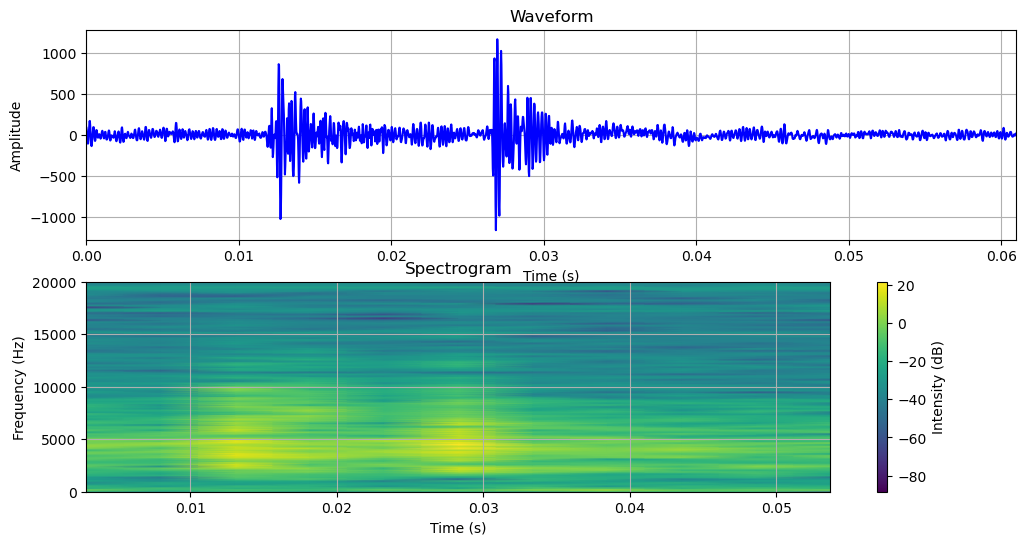

In [116]:
# Display audio segment
audio_segment = keystrokes[0]


def display_audio(audio, audio_start=None, times=None):
    samples = np.array(audio.get_array_of_samples())
    # Handles stereo
    if audio.channels == 2:
        samples = samples.reshape((-1, 2))
    
    # Create a time array for the x-axis
    time = np.linspace(0, len(samples) / audio.frame_rate, num=len(samples))
    if audio_start is not None:
        start = audio_start / 1000.
        time = np.linspace(start, len(samples) / audio.frame_rate, num=len(samples))
    print(time)

    # Plotting the waveform
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, samples, color='blue')
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.xlim(time[0], time[-1])
    plt.grid()

    if times is not None:
        for start, end in times:
            plt.axvspan(start/1000, end/1000, color='red', alpha=0.5)  # Adjust color and transparency
            plt.axvline(x=start/1000, color='black', linestyle='--', linewidth=1)  # Start line
            plt.axvline(x=end/1000, color='black', linestyle='--', linewidth=1)    # End line


    # Create a spectrogram
    frequencies, times, Sxx = spectrogram(samples[:], fs=audio.frame_rate)  # Use one channel for spectrogram

    # Plotting the spectrogram
    plt.subplot(2, 1, 2)
    plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
    plt.title('Spectrogram')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.colorbar(label='Intensity (dB)')
    plt.ylim(0, 20000)  # Limit frequency range to 20 kHz for better visibility
    plt.grid()

    plt.show()


display_audio(audio_segment)
play(audio_segment)

[0.00000000e+00 2.26757389e-05 4.53514779e-05 ... 2.59877687e+02
 2.59877710e+02 2.59877732e+02]


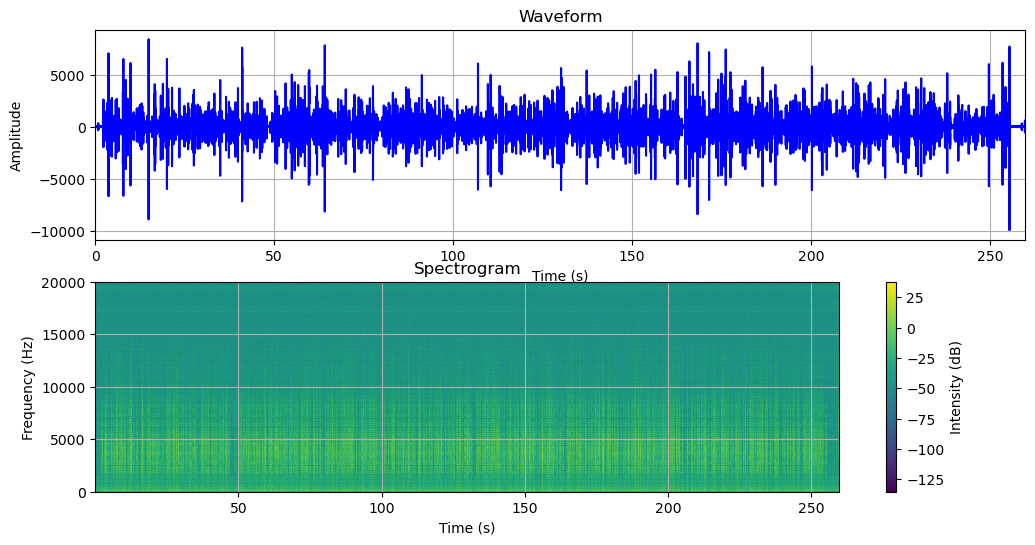

In [7]:
display_audio(audio)

[0.8        0.80000756 0.80001512 ... 1.19998488 1.19999244 1.2       ]


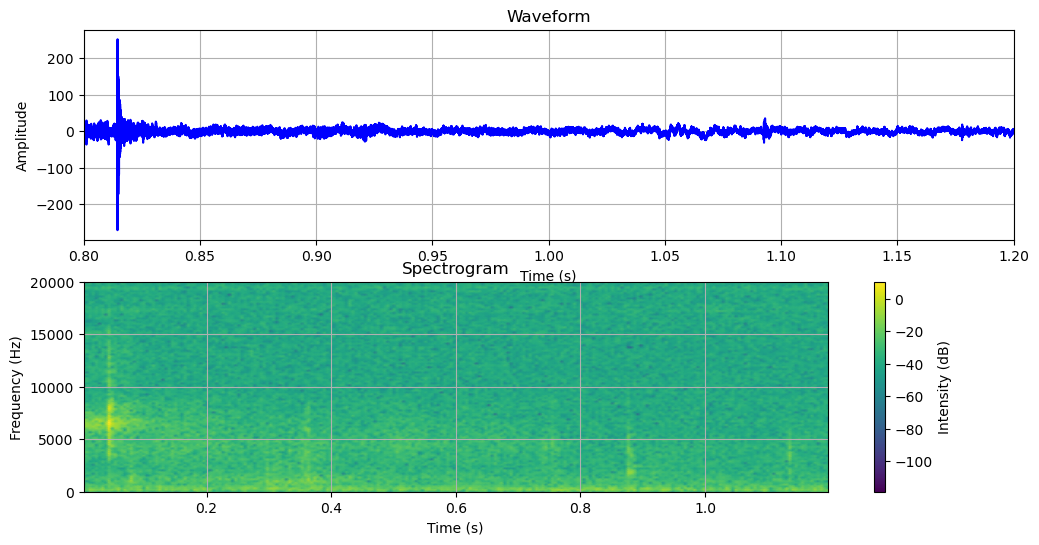

In [64]:
audio_segment = audio[800:2000]
display_audio(audio_segment, audio_start=800)
play(audio_segment)

In [65]:
"""
Written by Shoyo Inokuchi (June 2019)

Scripts for the acoustic keylogger surrounding feature extraction.
Repository is located at: https://github.com/shoyo-inokuchi/acoustic-keylogger
"""
from librosa.feature import mfcc


def extract_features(keystroke, sr=44100, n_mfcc=16, n_fft=441, hop_len=110):
    """Return an MFCC-based feature vector for a given keystroke."""
    spec = mfcc(y=keystroke.astype(float),
                sr=sr,
                n_mfcc=n_mfcc,
                n_fft=n_fft, # n_fft=220 for a 10ms window
                hop_length=hop_len, # hop_length=110 for ~2.5ms
                )
    return spec.flatten()

In [117]:
# make a pandas DataFrame from all of the keystroke samples

def convert_to_array(list_of_keys):
    list_of_arrays = []
    for key in list_of_keys:
        key_array = np.array(key.get_array_of_samples())
        list_of_arrays.append(extract_features(key_array, sr=key.frame_rate))
    
    return list_of_arrays

key_df = pd.DataFrame(convert_to_array(keystrokes))
print(key_df.shape)

# Replace nan values in the last keystroke
key_df.fillna(0, inplace=True)

key_df.head()

c:\Users\nmcph\anaconda3\envs\heimdall\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


(499, 7904)


,0,1,2,3,4,5,6,7,8,9,...,7894,7895,7896,7897,7898,7899,7900,7901,7902,7903
0,245.597040,241.881583,228.276955,220.325788,285.885331,348.398324,349.990112,320.844293,279.768111,267.142833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,383.650354,364.853799,290.395808,270.256029,289.993111,350.262280,332.485430,288.606232,264.261187,253.363060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,167.507837,172.167015,172.367052,167.813126,168.169639,166.744882,156.255124,161.280132,167.893557,174.967260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,196.675729,210.169035,259.591957,315.676574,361.029370,357.203362,289.261209,263.497018,258.781306,241.938586,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,115.512703,139.097408,137.758298,131.057808,138.490386,137.336975,138.916596,143.738244,141.018163,143.207815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
import os
os.environ["OMP_NUM_THREADS"] = "5"

c:\Users\nmcph\anaconda3\envs\heimdall\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\nmcph\anaconda3\envs\heimdall\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\nmcph\anaconda3\envs\heimdall\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\nmcph\anaconda3\envs\heimdall\lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

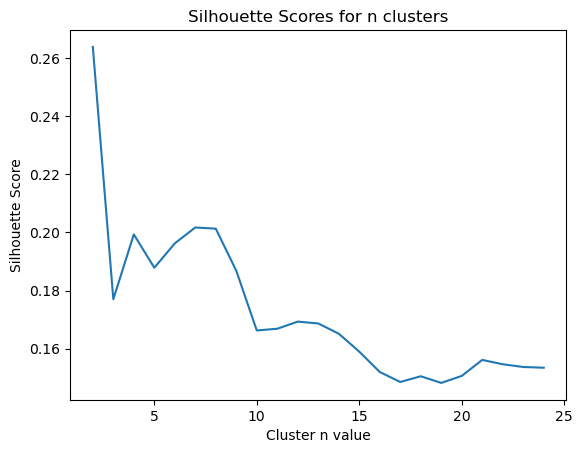

In [121]:
# Perform k-means clustering on the keystrokes
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_scores = []
for i in range(2, 25):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init="auto").fit(key_df.to_numpy())
    sil_scores.append(silhouette_score(key_df.to_numpy(), kmeans.labels_))

cluster_k = len(set(labels))
kmeans = KMeans(n_clusters=cluster_k, random_state=0, n_init="auto").fit(key_df.to_numpy())
predicted_clusters = []
for keystroke in key_df.to_numpy():
    predicted_clusters.append(kmeans.predict(keystroke.reshape(1, -1)))

predicted_clusters = np.array(predicted_clusters).squeeze()

plt.plot(range(2, 25), sil_scores)
plt.title("Silhouette Scores for n clusters")
plt.xlabel("Cluster n value")
plt.ylabel("Silhouette Score")
plt.show()

(499, 7904)


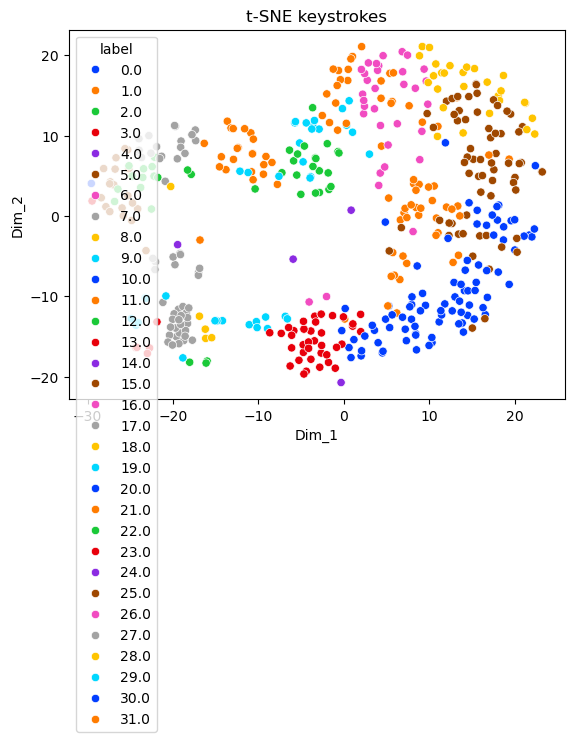

In [122]:
# Plot the data with t-SNE dimensionality reduction to determine if the keystrokes make clusters

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sn

# Scale data
standardized_data = StandardScaler().fit_transform(key_df)
print(standardized_data.shape)

def tsne_plot(data, labels=None):
    model = TSNE(n_components = 2, random_state = 0)
    # configuring the parameters
    # the number of components = 2
    # default perplexity = 30
    # default learning rate = 200
    # default Maximum number of iterations
    # for the optimization = 1000
    
    tsne_data = model.fit_transform(data)
    
    # Colors points based on their label, if they have any
    if labels is not None:
        tsne_data = np.vstack((tsne_data.T, labels)).T
        tsne_df = pd.DataFrame(data = tsne_data,
           columns =("Dim_1", "Dim_2", "label"))
    
        # Plotting the result of tsne
        sn.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2',
                       hue='label', palette="bright")
    else:
        tsne_df = pd.DataFrame(data = tsne_data,
           columns =("Dim_1", "Dim_2"))
    
        # Plotting the result of tsne
        sn.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2', palette="bright")

    plt.title("t-SNE keystrokes")
    plt.show()

tsne_plot(standardized_data, predicted_clusters)